In [1]:
import sys
sys.path.insert(0, '/home/users/brezovec/.local/lib/python3.6/site-packages/lib/python/')
import ants
import os
import bigbadbrain as bbb
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy
from scipy.ndimage.filters import gaussian_filter
from scipy.ndimage.filters import gaussian_filter1d
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d

from skimage.filters import threshold_triangle
sys.path.insert(0, '/home/users/brezovec/.local/lib/python3.6/site-packages')
import os
import statsmodels.api as sm
import cv2
import matplotlib.patches as mpatches
import psutil
from mpl_toolkits.axes_grid1 import ImageGrid
from matplotlib.colors import Normalize
import matplotlib.colors as mcolors
from matplotlib import colors

%matplotlib inline
plt.rcParams.update({'font.size': 20})

from sklearn.feature_extraction.image import grid_to_graph
from mpl_toolkits.axes_grid1 import ImageGrid
import json
from matplotlib.ticker import FuncFormatter

import nibabel as nib

from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import fcluster
from scipy.cluster import hierarchy
import itertools
import random
import matplotlib as mpl
from matplotlib.pyplot import cm

from scipy.interpolate import UnivariateSpline
from sklearn.linear_model import LinearRegression
import matplotlib.patches as patches

from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV

from scipy.fftpack import fft,fftshift,ifft
from scipy import signal
import pickle

In [2]:
luke_path = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/anat_templates/luke_lowres.nii"
luke = np.asarray(nib.load(luke_path).get_data().squeeze(), dtype='float32')

In [3]:
file = F'/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20210130_superv_depth_correction/20210214_eigen_vectors_ztrim.npy'
vectors = np.load(file).real
print(f'vectors are {vectors.shape} voxel by PC')

vectors are (26840, 26840) voxel by PC


In [4]:
labels_file = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20210130_superv_depth_correction/labels.pickle'
with open(labels_file, 'rb') as handle:
    cluster_model_labels = pickle.load(handle)

In [5]:
running_sum = 0
new = []
for z in range(9,49-9):
    num_clusters = len(np.unique(cluster_model_labels[z]))
    new.append(vectors[running_sum:num_clusters+running_sum,:])
    running_sum += num_clusters

In [6]:
maps = []
for pc in range(10):
    all_ = []
    for z in range(9,49-9):
        colored_by_betas = np.zeros((256*128))
        for cluster_num in range(len(np.unique(cluster_model_labels[z]))):
            cluster_indicies = np.where(cluster_model_labels[z][:]==cluster_num)[0]
            colored_by_betas[cluster_indicies] = new[z-9][cluster_num,pc]
        colored_by_betas = colored_by_betas.reshape(256,128)
        all_.append(colored_by_betas)
    all_ = np.asarray(all_)
    maps.append(all_)
maps = np.asarray(maps)

In [7]:
maps.shape

(10, 31, 256, 128)

In [8]:
maps = np.moveaxis(maps,1,-1)
maps = np.moveaxis(maps,0,-1)
maps.shape

(256, 128, 31, 10)

In [9]:
pad = np.zeros((256,128,9,10))
out = np.concatenate((pad,maps,pad),axis=2)
out.shape

(256, 128, 49, 10)

In [10]:
### Load for warping to JRC space ###

fixed_path = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/anat_templates/JRC2018_FEMALE_38um_iso_16bit.nii"
res_JRC2018 = (0.38, 0.38, 0.38)
fixed = np.asarray(nib.load(fixed_path).get_data().squeeze(), dtype='float32')
fixed = ants.from_numpy(fixed)
fixed.set_spacing(res_JRC2018)
fixed = ants.resample_image(fixed,(256,128,49),1,interp_type=1) #nearest neighbor
#fixed = ants.resample_image(fixed,res_LUKE,0,0)

affine_file = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/anat_templates/luke-to-jrc2018_fwdtransforms_lowres/tmps47el_wi0GenericAffine.mat"

In [11]:
res_LUKE = (2.6, 2.6, 5, 1)
moving = ants.from_numpy(out[:,:,::-1,:])
moving.set_spacing(res_LUKE)

In [12]:
maps = ants.apply_transforms(fixed, moving, affine_file, imagetype=3, interpolator='nearestNeighbor')

(-0.5, 255.5, 127.5, -0.5)

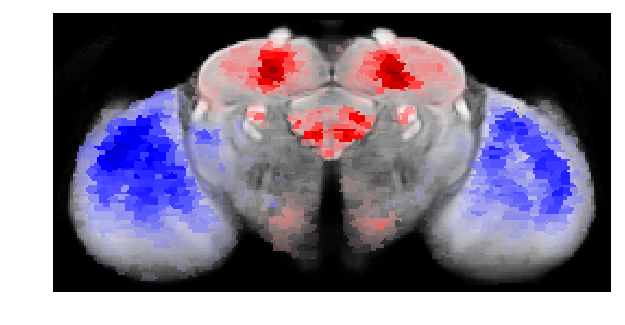

In [35]:
plt.figure(figsize=(10,10))
z=25
pc=1

plt.imshow(luke[:,:,z].T,cmap='gray')
alphas = Normalize(.0001, .01, clip=True)(np.abs(maps[:,:,z,pc]))
alphas = np.clip(alphas, 0, 1)  # alpha value clipped at the bottom
# Normalize the colors b/w 0 and 1, we'll then pass an MxNx4 array to imshow
colors = Normalize(-.03, .03)(maps[:,:,z,pc])
cmap = plt.cm.seismic
colors = cmap(colors)
# Now set the alpha channel to the one we created above
colors[..., -1] = alphas
plt.imshow(np.swapaxes(colors,0,1))
plt.axis('off')

In [22]:
def alpha_gradient(maps):
    alphas = Normalize(.0001, .005, clip=True)(np.abs(maps))
    alphas = np.clip(alphas, 0, 1)  # alpha value clipped at the bottom
    # Normalize the colors b/w 0 and 1, we'll then pass an MxNx4 array to imshow
    colors = Normalize(-.01, .01)(maps)
    cmap = plt.cm.PuOr
    colors = cmap(colors)
    # Now set the alpha channel to the one we created above
    colors[..., -1] = alphas
    return colors

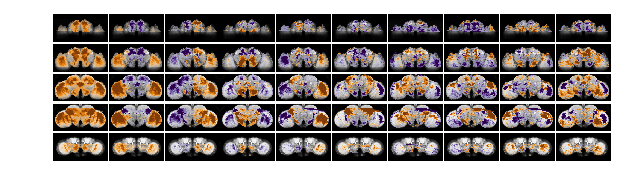

In [23]:
plt.figure(figsize=(10,10))

i=0
for z in [12,19,26,31,39]:#39
    for pc in range(10):
        plt.subplot(5,10,i+1)
        plt.imshow(luke[:,:,z].T,cmap='gray')
        colors = alpha_gradient(maps[:,:,z,pc])
        plt.imshow(np.swapaxes(colors,0,1))
        plt.axis('off')
        i+=1

plt.subplots_adjust(wspace=0.02, hspace=-.93)
save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}')
#plt.savefig(fname,dpi=300,bbox_inches='tight')

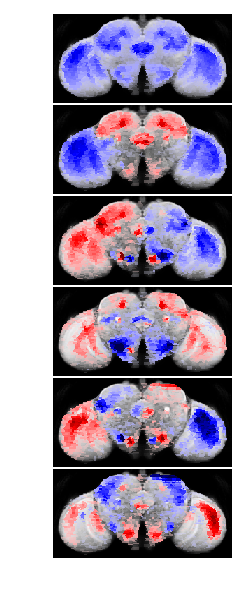

In [56]:
plt.figure(figsize=(10,10))

i=0
z=27
for pc in range(6):
    plt.subplot(6,1,i+1)
    plt.imshow(luke[:,:,z].T,cmap='gray')
    colors = alpha_gradient(maps[:,:,z,pc])
    plt.imshow(np.swapaxes(colors,0,1))
    plt.axis('off')
    i+=1

plt.subplots_adjust(wspace=0.02, hspace=.02)
save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}')
plt.savefig(fname,dpi=300,bbox_inches='tight')

# Temporal

In [3]:
file = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20210130_superv_depth_correction/20210214_temporal.npy'
temporal = np.load(file)
temporal = temporal*-1
temporal.shape #timepoint by PC

(30456, 1000)

In [4]:
dataset_path = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset"
fly_names = ['fly_087', 'fly_089', 'fly_094', 'fly_097', 'fly_098', 'fly_099', 'fly_100', 'fly_101', 'fly_105']
expt_len = 1000*30*60
resolution = 10
high_res_timepoints = np.arange(0,expt_len,resolution) #0 to last time at subsample res

In [5]:
class Fictrac:
    def __init__ (self, fly_dir, timestamps):
        self.fictrac_raw = bbb.load_fictrac(os.path.join(fly_dir, 'fictrac'))
        self.timestamps = timestamps
    def make_interp_object(self, behavior):
        # Create camera timepoints
        fps=50
        camera_rate = 1/fps * 1000 # camera frame rate in ms
        expt_len = 1000*30*60
        x_original = np.arange(0,expt_len,camera_rate)

        # Smooth raw fictrac data
        fictrac_smoothed = scipy.signal.savgol_filter(np.asarray(self.fictrac_raw[behavior]),25,3)

        # Create interp object with camera timepoints
        fictrac_interp_object = interp1d(x_original, fictrac_smoothed, bounds_error = False)
        return fictrac_interp_object

    def pull_from_interp_object(self, interp_object, timepoints):
        new_interp = interp_object(timepoints)
        np.nan_to_num(new_interp, copy=False);
        return new_interp

    def interp_fictrac(self, z):
        behaviors = ['dRotLabY', 'dRotLabZ']; shorts = ['Y', 'Z']
        self.fictrac = {}

        for behavior, short in zip(behaviors, shorts):
            interp_object = self.make_interp_object(behavior)
            self.fictrac[short + 'i'] = interp_object

            ### Velocity ###
            low_res_behavior = self.pull_from_interp_object(interp_object, self.timestamps[:,z])
            self.fictrac[short] = low_res_behavior#/np.std(low_res_behavior)
            
            ### Clipped Velocities ###
            self.fictrac[short + '_pos'] = np.clip(self.fictrac[short], a_min=0, a_max=None)
            self.fictrac[short + '_neg'] = np.clip(self.fictrac[short], a_min=None, a_max=0)*-1
            
            ### Strongly Clipped Velocities ###
            # excludes points even close to 0
            #self.fictrac[short + '_pos_very'] = np.clip(self.fictrac[short], a_min=0.3, a_max=None)
            #self.fictrac[short + '_neg_very'] = np.clip(self.fictrac[short], a_min=None, a_max=-0.3)*-1

            ### Acceleration ###
            high_res_behavior = self.pull_from_interp_object(interp_object, high_res_timepoints)
            self.fictrac[short + 'h'] = high_res_behavior/np.std(high_res_behavior)

            accel = scipy.signal.savgol_filter(np.diff(high_res_behavior),25,3)
            accel = np.append(accel, 0)
            interp_object = interp1d(high_res_timepoints, accel, bounds_error = False)
            acl = interp_object(self.timestamps[:,z])
            acl[-1] = 0
            self.fictrac[short + 'a'] = acl#/np.std(acl)
            
            ### Clipped Acceleration ###
            self.fictrac[short + 'a' + '_pos'] = np.clip(self.fictrac[short + 'a'], a_min=0, a_max=None)
            self.fictrac[short + 'a' + '_neg'] = np.clip(self.fictrac[short + 'a'], a_min=None, a_max=0)*-1

        self.fictrac['YZ'] = np.sqrt(np.power(self.fictrac['Y'],2), np.power(self.fictrac['Z'],2))
        self.fictrac['YZh'] = np.sqrt(np.power(self.fictrac['Yh'],2), np.power(self.fictrac['Zh'],2))

class Fly:
    def __init__ (self, fly_name, fly_idx):
        self.dir = os.path.join(dataset_path, fly_name, 'func_0')
        self.fly_idx = fly_idx
        self.fly_name = fly_name
        self.maps = {}
    def load_timestamps (self):
        self.timestamps = bbb.load_timestamps(os.path.join(self.dir, 'imaging'))
    def load_fictrac (self):
        self.fictrac = Fictrac(self.dir, self.timestamps)
    def load_brain_slice (self):
        self.brain = brain[:,:,:,self.fly_idx]
    def load_anatomy (self):
        to_load = os.path.join(dataset_path, self.fly_name, 'warp', 'anat-to-meanbrain.nii')
        self.anatomy = np.array(nib.load(to_load).get_data(), copy=True)
    def load_z_depth_correction (self):
        to_load = os.path.join(dataset_path, self.fly_name, 'warp', '20201220_warped_z_depth.nii')
        self.z_correction = np.array(nib.load(to_load).get_data(), copy=True)
    def get_cluster_averages (self, cluster_model_labels, n_clusters):
        neural_data = self.brain.reshape(-1, 3384)
        signals = []
        self.cluster_indicies = []
        for cluster_num in range(n_clusters):
            cluster_indicies = np.where(cluster_model_labels==cluster_num)[0]
            mean_signal = np.mean(neural_data[cluster_indicies,:], axis=0)
            signals.append(mean_signal)
            self.cluster_indicies.append(cluster_indicies) # store for later
        self.cluster_signals=np.asarray(signals)
    def get_cluster_id (self, x, y):
        ax_vec = x*128 + y
        for i in range(n_clusters):
            if ax_vec in self.cluster_indicies[i]:
                cluster_id = i
                break
        return cluster_id

In [6]:
expt_len = 1000*30*60
resolution = 10
high_res_timepoints = np.arange(0,expt_len,resolution) #0 to last time at subsample res

class Fictrac:
    def __init__ (self, fly_dir, timestamps):
        self.fictrac_raw = bbb.load_fictrac(os.path.join(fly_dir, 'fictrac'))
        self.timestamps = timestamps
    def make_interp_object(self, behavior):
        # Create camera timepoints
        fps=50
        camera_rate = 1/fps * 1000 # camera frame rate in ms
        expt_len = 1000*30*60
        x_original = np.arange(0,expt_len,camera_rate)

        # Smooth raw fictrac data
        fictrac_smoothed = scipy.signal.savgol_filter(np.asarray(self.fictrac_raw[behavior]),25,3)

        # Create interp object with camera timepoints
        fictrac_interp_object = interp1d(x_original, fictrac_smoothed, bounds_error = False)
        return fictrac_interp_object

    def pull_from_interp_object(self, interp_object, timepoints):
        new_interp = interp_object(timepoints)
        np.nan_to_num(new_interp, copy=False);
        return new_interp

    def interp_fictrac(self):
        behaviors = ['dRotLabY', 'dRotLabZ']; shorts = ['Y', 'Z']
        self.fictrac = {}

        ### Y and Z ###
        for behavior, short in zip(behaviors, shorts):
            interp_object = self.make_interp_object(behavior)
            self.fictrac[short + 'i'] = interp_object

            ### Interpolate to neural data
            self.fictrac[short] = []
            self.fictrac[short + '_pos'] = []
            self.fictrac[short + '_neg'] = []
            for z in range(49):
                ### Velocity ###
                low_res_behavior = self.pull_from_interp_object(interp_object, self.timestamps[:,z])
                #self.fictrac[short].append(low_res_behavior/np.std(low_res_behavior))
                self.fictrac[short].append(low_res_behavior)

                ### Clipped Velocities ###
                self.fictrac[short + '_pos'].append(np.clip(self.fictrac[short][-1], a_min=0, a_max=None))
                self.fictrac[short + '_neg'].append(np.clip(self.fictrac[short][-1], a_min=None, a_max=0)*-1)
                
            ### 10Hz interp ###
            expt_len = 1000*30*60
            sample_in_ms = 100
            x_hz10 = np.arange(0,expt_len,sample_in_ms)
            hz10_res_behavior = self.pull_from_interp_object(interp_object, x_hz10)
            self.fictrac[short + '_10hz'] = hz10_res_behavior
            self.fictrac[short + '_pos_10hz'] = np.clip(hz10_res_behavior, a_min=0, a_max=None)
            self.fictrac[short + '_neg_10hz'] = np.clip(hz10_res_behavior, a_min=None, a_max=0) * -1

        ### Walking ###
        self.fictrac['walking'] = []
        for z in range(49):    
            YZ = np.sqrt(np.power(self.fictrac['Y'][z],2), np.power(self.fictrac['Z'][z],2))        
            self.fictrac['walking'].append(np.zeros(3384))
            self.fictrac['walking'][-1][np.where(YZ>.2)] = 1

class Fly:
    def __init__ (self, fly_name, fly_idx):
        self.dir = os.path.join(dataset_path, fly_name, 'func_0')
        self.fly_idx = fly_idx
        self.fly_name = fly_name
        self.maps = {}
    def load_timestamps (self):
        self.timestamps = bbb.load_timestamps(os.path.join(self.dir, 'imaging'))
    def load_fictrac (self):
        self.fictrac = Fictrac(self.dir, self.timestamps)
    def load_brain_slice (self):
        self.brain = brain[:,:,:,self.fly_idx]
    def load_anatomy (self):
        to_load = os.path.join(dataset_path, self.fly_name, 'warp', 'anat-to-meanbrain.nii')
        self.anatomy = np.array(nib.load(to_load).get_data(), copy=True)
    def load_z_depth_correction (self):
        to_load = os.path.join(dataset_path, self.fly_name, 'warp', '20201220_warped_z_depth.nii')
        self.z_correction = np.array(nib.load(to_load).get_data(), copy=True)
    def get_cluster_averages (self, cluster_model_labels, n_clusters):
        neural_data = self.brain.reshape(-1, 3384)
        signals = []
        self.cluster_indicies = []
        for cluster_num in range(n_clusters):
            cluster_indicies = np.where(cluster_model_labels==cluster_num)[0]
            mean_signal = np.mean(neural_data[cluster_indicies,:], axis=0)
            signals.append(mean_signal)
            self.cluster_indicies.append(cluster_indicies) # store for later
        self.cluster_signals=np.asarray(signals)
    def get_cluster_id (self, x, y):
        ax_vec = x*128 + y
        for i in range(n_clusters):
            if ax_vec in self.cluster_indicies[i]:
                cluster_id = i
                break
        return cluster_id

In [7]:
flies = {}
for i, fly in enumerate(fly_names):
    print(F'*** fly: {fly} ***')
    flies[fly] = Fly(fly_name=fly, fly_idx=i)
    flies[fly].load_timestamps()
    flies[fly].load_fictrac()
    flies[fly].fictrac.interp_fictrac()

*** fly: fly_087 ***

~~ load_timestamps ~~
Trying to load timestamp data from hdf5 file.
Success.
load_timestamps done. Duration: 11.90 ms

~~ load_fictrac ~~
load_fictrac done. Duration: 3.35 sec
*** fly: fly_089 ***

~~ load_timestamps ~~
Trying to load timestamp data from hdf5 file.
Success.
load_timestamps done. Duration: 6.72 ms

~~ load_fictrac ~~
load_fictrac done. Duration: 3.32 sec
*** fly: fly_094 ***

~~ load_timestamps ~~
Trying to load timestamp data from hdf5 file.
Success.
load_timestamps done. Duration: 8.12 ms

~~ load_fictrac ~~
load_fictrac done. Duration: 3.36 sec
*** fly: fly_097 ***

~~ load_timestamps ~~
Trying to load timestamp data from hdf5 file.
Success.
load_timestamps done. Duration: 6.51 ms

~~ load_fictrac ~~
load_fictrac done. Duration: 3.33 sec
*** fly: fly_098 ***

~~ load_timestamps ~~
Trying to load timestamp data from hdf5 file.
Success.
load_timestamps done. Duration: 6.33 ms

~~ load_fictrac ~~
load_fictrac done. Duration: 3.36 sec
*** fly: fly_0

In [8]:
z = 20
sphere_radius = 4.5e-3 # in m
fps=50
behaviors = ['Y', 'Z', 'Y_pos', 'Z_pos', 'Z_neg']
behavior_super = {}
for behavior in behaviors:
    behavior_super[behavior] = []
    for fly in fly_names:
        behavior_super[behavior].extend((flies[fly].fictrac.fictrac[behavior][z]))
    behavior_super[behavior] = np.asarray(behavior_super[behavior])
    behavior_super[behavior + '_std'] = behavior_super[behavior]/np.std(behavior_super[behavior])
    
    if behavior in ['Y', 'Y_pos']:
        ''' starts with units of rad/frame
        * sphere_radius(m); now in m/frame
        * fps; now in m/sec
        * 1000; now in mm/sec '''
        behavior_super[behavior + '_units'] = behavior_super[behavior] * sphere_radius * fps * 1000 # mm/sec
        
    elif behavior in ['Z', 'Z_pos', 'Z_neg']:
        ''' starts with units of rad/frame
        * 180 / np.pi; now in deg/frame
        * fps; now in deg/sec '''
        behavior_super[behavior + '_units'] = behavior_super[behavior] * 180 / np.pi * fps ## deg/sec

In [9]:
def bin_2D(pc, num_bins_x, num_bins_y, idx_x ,idx_y):
    #"PC" is just a holdover
    pc_binned = []
    pc_std = []
    pc_count = []
    pc_var = []
    for i in range(num_bins_x):
        mask_x = (idx_x == i)
        for j in range(num_bins_y):
            mask_y = (idx_y == j)
            mask = mask_x & mask_y
            pc_binned.append(np.mean(pc[mask]))
            pc_std.append(np.std(pc[mask]))
            pc_count.append(np.count_nonzero(~np.isnan(pc[mask])))
            pc_var.append(np.var(pc[mask]))
    pc_binned = np.flip(np.reshape(pc_binned,(num_bins_x, num_bins_y)).T,0)
    pc_std = np.flip(np.reshape(pc_std,(num_bins_x, num_bins_y)).T,0)
    pc_count = np.flip(np.reshape(pc_count,(num_bins_x, num_bins_y)).T,0)
    pc_var = np.flip(np.reshape(pc_var,(num_bins_x, num_bins_y)).T,0)
    pcs_binned = {'pc_binned': pc_binned,
                  'pc_std': pc_std,
                  'pc_count':pc_count,
                  'pc_var':pc_var}
    return pcs_binned

def bin_2D_plot(x_data, y_data, value_data, num_bins_x, num_bins_y, start_x, end_x, start_y, end_y, min_num_samples):
    # Define bins
    bins_x, bins_y = np.linspace(start_x,end_x,num_bins_x), np.linspace(start_y,end_y,num_bins_y)
    #bins_x = np.concatenate((np.linspace(start_x,0,num_bins_x)[:-1], np.linspace(0,end_x,num_bins_x)))
    #bins_y = np.concatenate((np.linspace(start_y,0,num_bins_y)[:-1], np.linspace(0,end_y,num_bins_y)))
    
#     bins_x = [x / 10.0 for x in range(-20, 64, 4)]
#     bins_y = [x / 10.0 for x in range(-40, 44, 4)]
#     num_bins_x = 22
#     num_bins_y = 22
    
    # Assign fictrac values to bin numbers
    idx_x, idx_y = np.digitize(x_data,bins_x), np.digitize(y_data,bins_y)

    test = bin_2D(value_data, num_bins_x, num_bins_y, idx_x ,idx_y)
    
    # Hide bins containing too few data points
    test['pc_binned'][np.where(test['pc_count']<=min_num_samples)] = 0
    return test['pc_binned'], bins_x, bins_y

def plot_2D_hist(fig, fly, behavior_type, x_pos, y_pos):
    ax = fig.add_axes([x_pos,y_pos,.05,.05])

    if behavior_type == 'velocity':
        X_var = flies[fly].fictrac.fictrac['Y']
        Y_var = flies[fly].fictrac.fictrac['Z']
        signal = flies[fly].cluster_signals[flies[fly].get_cluster_id(x, y), :]
    if behavior_type == 'velocity_pooled':
        X_var = pooled_behavior['Y']
        Y_var = pooled_behavior['Z']
        signal = temporal[:,0]
    if behavior_type == 'acceleration':
        X_var = flies[fly].fictrac.fictrac['Ya']
        Y_var = flies[fly].fictrac.fictrac['Za']
        signal = flies[fly].cluster_signals[flies[fly].get_cluster_id(x, y), :]
    if behavior_type == 'acceleration_pooled':
        X_var = pooled_behavior['Ya']
        Y_var = pooled_behavior['Za']
        signal = pooled_activity
       
    if behavior_type in ['velocity', 'velocity_pooled']:
        start_x=-2; end_x=8; start_y=-5; end_y=5
        ax.axhline(4.5,linestyle='--',color='k',linewidth=1)
        ax.axvline(1.5,linestyle='--',color='k',linewidth=1)
    if behavior_type in ['acceleration', 'acceleration_pooled']:
        start_x=-5; end_x=5; start_y=-5; end_y=5
        ax.axhline(4.5,linestyle='--',color='k',linewidth=1)
        ax.axvline(4.5,linestyle='--',color='k',linewidth=1)
    
    fictrac_2d, bins_x, bins_y = bin_2D_plot(X_var, Y_var, signal,
                                             num_bins_x=10, num_bins_y=10,
                                             start_x=start_x, end_x=end_x, start_y=start_y, end_y=end_y)
    
    ax.imshow(fictrac_2d,cmap='PuOr',vmin=-1,vmax=1)
    ax.yaxis.set_visible(False)
    ax.xaxis.set_visible(False)
    
def plot_2D_scatter(fig, fly, behavior_type, x_pos, y_pos):
    ax = fig.add_axes([x_pos,y_pos,.05,.05])

    if behavior_type == 'velocity':
        X_var = flies[fly].fictrac.fictrac['Y']
        Y_var = flies[fly].fictrac.fictrac['Z']
        signal = flies[fly].cluster_signals[flies[fly].get_cluster_id(x, y), :]
        ax.set_ylim(-5,5)
        ax.set_xlim(-2,8)
    if behavior_type == 'acceleration':
        X_var = flies[fly].fictrac.fictrac['Ya']
        Y_var = flies[fly].fictrac.fictrac['Za']
        signal = flies[fly].cluster_signals[flies[fly].get_cluster_id(x, y), :]
        ax.set_ylim(-5,5)
        ax.set_xlim(-5,5)
    if behavior_type == 'velocity_pooled':
        X_var = pooled_behavior['Y']
        Y_var = pooled_behavior['Z']
        signal = pooled_activity
        ax.set_ylim(-5,5)
        ax.set_xlim(-2,8)
    if behavior_type == 'acceleration_pooled':
        X_var = pooled_behavior['Ya']
        Y_var = pooled_behavior['Za']
        signal = pooled_activity
        ax.set_ylim(-5,5)
        ax.set_xlim(-5,5)
    
    ax.scatter(x=X_var,
               y=Y_var,
               c=signal,
               marker='x',cmap='PuOr',vmin=-1,vmax=1,s=.5,linewidth=.1) #s,.2,lw=0
    
    ax.yaxis.set_visible(False)
    ax.xaxis.set_visible(False)
    ax.axhline(0,linestyle='--',color='k',linewidth=1)
    ax.axvline(0,linestyle='--',color='k',linewidth=1)

In [10]:
from matplotlib.colors import ListedColormap

In [12]:
# define top and bottom colormaps 
top = cm.get_cmap('Oranges_r', 128) # r means reversed version
bottom = cm.get_cmap('Blues', 128)# combine it all
newcolors = np.vstack((top(np.linspace(0, 1, 128)),
                       bottom(np.linspace(0, 1, 128))))# create a new colormaps with a name of OrangeBlue
orange_blue = ListedColormap(newcolors, name='OrangeBlue')

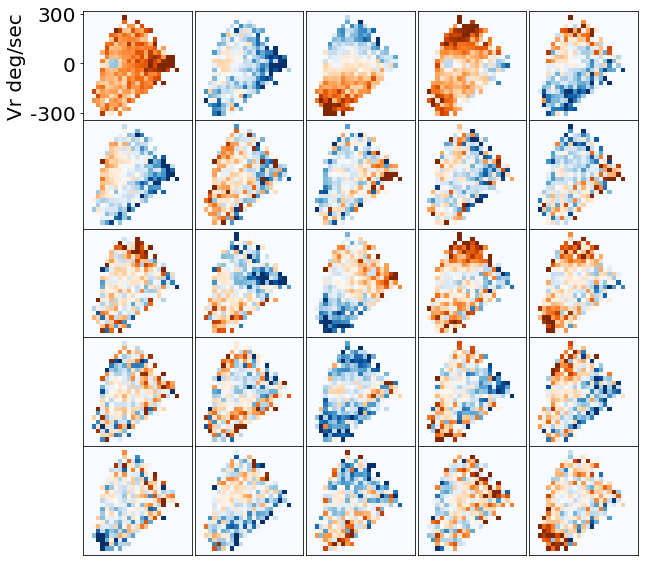

In [113]:
X_var = behavior_super['Y_std']
Y_var = behavior_super['Z_std']
fig = plt.figure(figsize=(10,10))
#ax = fig.add_axes([0,0,1,1])
start_x=-2; end_x=6; start_y=-4; end_y=4

for k in range(25):
    signal = temporal[:,k]
    plt.subplot(5,5,k+1)
    fictrac_2d, bins_x, bins_y = bin_2D_plot(X_var, Y_var, signal,
                                     num_bins_x=25, num_bins_y=25,
                                     start_x=start_x, end_x=end_x, start_y=start_y, end_y=end_y,
                                     min_num_samples=9)

    fictrac_2d[-1,:] = 0
    #vmax = np.percentile(fictrac_2d,99)
    vmax = np.percentile(np.abs(fictrac_2d),98)
    plt.imshow(fictrac_2d[:,:],cmap=orange_blue,vmin=-vmax,vmax=vmax,extent=[-2.35,6,-4.35,4])
    #plt.imshow(fictrac_2d[:,:],cmap=orange_blue,vmin=-7,vmax=7,extent=[-2.35,6,-4.35,4])

    ax = plt.gca()
    if k == 0:
        
        ratio = np.max(behavior_super['Z_std'])/np.max(behavior_super['Z_units'])
        ax.set_yticklabels([-300, 0, 300])
        ax.set_yticks([-300*ratio, 0, 300*ratio])

        ratio = np.max(behavior_super['Y_std'])/np.max(behavior_super['Y_units'])
        ax.set_xticklabels([0, 10])
        ax.set_xticks([0, 10*ratio])

        plt.ylabel('Vr deg/sec')
        plt.xlabel('Vf mm/sec')
    else:
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
    
    #ax.axhline(0,linestyle='--',color='k',linewidth=1)
    #ax.axvline(0,linestyle='--',color='k',linewidth=1)
plt.subplots_adjust(wspace=0, hspace=0)
save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}')
#plt.savefig(fname,dpi=300,bbox_inches='tight')

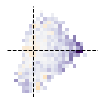

In [15]:
X_var = behavior_super['Y_std']
Y_var = behavior_super['Z_std']
fig = plt.figure(figsize=(10,10))
#ax = fig.add_axes([0,0,1,1])
start_x=-2; end_x=6; start_y=-4; end_y=4

for k in [1]:
    signal = temporal[:,k] * -1
    plt.subplot(6,1,k+1)
    fictrac_2d, bins_x, bins_y = bin_2D_plot(X_var, Y_var, signal,
                                     num_bins_x=25, num_bins_y=25,
                                     start_x=start_x, end_x=end_x, start_y=start_y, end_y=end_y,
                                     min_num_samples=9)

    fictrac_2d[-1,:] = 0
    #vmax = np.percentile(fictrac_2d,99)
    vmax = np.percentile(np.abs(fictrac_2d),98)
    fictrac_2d[np.where(fictrac_2d==0)]=np.nan
    vmax=5
    plt.imshow(fictrac_2d[:,:],cmap='PuOr',vmin=-vmax,vmax=vmax,extent=[-2.35,6,-4.35,4])
    #plt.imshow(fictrac_2d[:,:],cmap=orange_blue,vmin=-7,vmax=7,extent=[-2.35,6,-4.35,4])

    ax = plt.gca()

        
    ratio = np.max(behavior_super['Z_std'])/np.max(behavior_super['Z_units'])
    #ax.set_yticklabels([-300, 0, 300])
    #ax.set_yticks([-300*ratio, 0, 300*ratio])

    ratio = np.max(behavior_super['Y_std'])/np.max(behavior_super['Y_units'])
    #ax.set_xticklabels([0, 10])
    #ax.set_xticks([0, 10*ratio])

    #plt.ylabel('Vr deg/sec')
    #plt.xlabel('Vf mm/sec')

    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    plt.axis('off')
    ax.axhline(0,linestyle='--',color='k',linewidth=1)
    ax.axvline(0,linestyle='--',color='k',linewidth=1)
plt.subplots_adjust(wspace=0, hspace=0)
save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}')
plt.savefig(fname,dpi=300,bbox_inches='tight',transparent=True)

In [16]:
file = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20210130_superv_depth_correction/20210301_temporal.npy'
temporal_super = np.load(file)
temporal_super.shape #time by PC

(30456, 26840)

In [76]:
behavior_super.keys()

dict_keys(['Y', 'Y_std', 'Y_units', 'Z', 'Z_std', 'Z_units', 'Y_pos', 'Y_pos_std', 'Y_pos_units', 'Z_pos', 'Z_pos_std', 'Z_pos_units', 'Z_neg', 'Z_neg_std', 'Z_neg_units'])

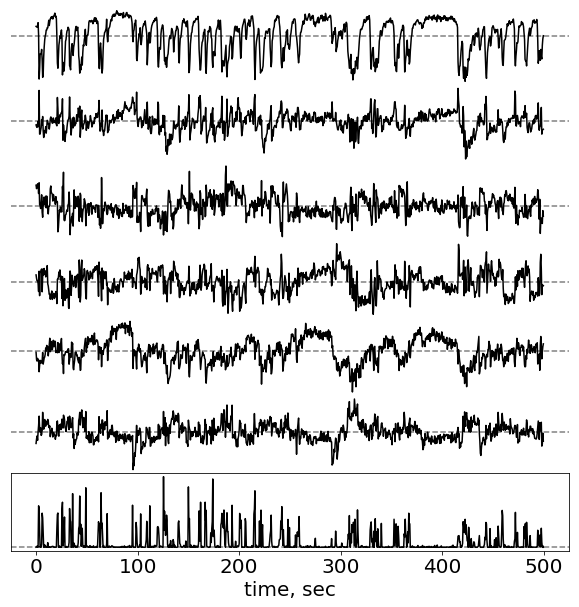

In [17]:
plt.figure(figsize=(10,10))
start = 8000
end = 9000

for i in range(7):
    plt.subplot(7,1,i+1)
    plt.axhline(0,color='grey',linestyle='--')
    if i == 6:
        plt.plot(behavior_super['Y_pos_units'][start:end],color='k')
        #plt.ylabel('Vf',rotation = 0,x=-100)
        ax = plt.gca()
        ax.set_yticks([])
    if i<6:
        plt.plot(temporal_super[start:end,i],color='k')
        #plt.ylabel(f'PC{i+1}',rotation = 0,x=-1000)
        ax = plt.gca()
        ax.set_yticks([])
        plt.axis('off')
    ax = plt.gca()
    ax.set_xticks([0,200,400,600,800,1000])
    ax.set_xticklabels([0,100,200,300,400,500])
    
    
plt.subplots_adjust(wspace=0, hspace=0)
plt.xlabel("time, sec")

save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}')
#plt.savefig(fname,dpi=300,bbox_inches='tight')

In [89]:
flies

{'fly_087': <__main__.Fly at 0x7f74fcc82828>,
 'fly_089': <__main__.Fly at 0x7f74f2303908>,
 'fly_094': <__main__.Fly at 0x7f74f18e4ba8>,
 'fly_097': <__main__.Fly at 0x7f74f0f33940>,
 'fly_098': <__main__.Fly at 0x7f74f052f908>,
 'fly_099': <__main__.Fly at 0x7f74efb7c940>,
 'fly_100': <__main__.Fly at 0x7f74ef14dba8>,
 'fly_101': <__main__.Fly at 0x7f74ee79b978>,
 'fly_105': <__main__.Fly at 0x7f74df570940>}

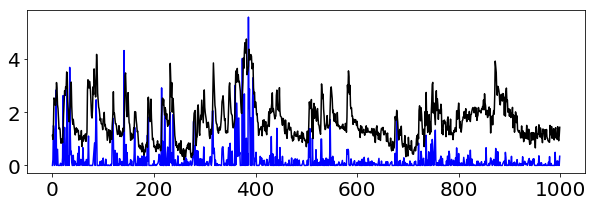

In [109]:
plt.figure(figsize=(10,3))
fly_num = 8
section = 2
start = fly_num*3384+1000*section
end = fly_num*3384+1000*section+1000
plt.plot(behavior_super['Y_pos_units'][start:end],color=(0,0,1))
plt.plot((temporal_super[start:end,0]*-0.2)+1.7,color='k')

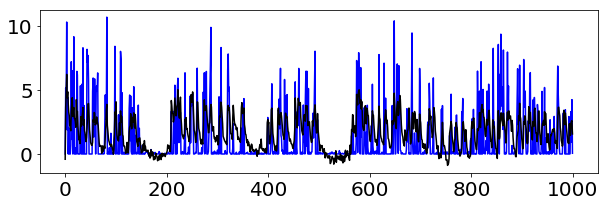

In [96]:
plt.figure(figsize=(10,3))
fly_num = 6
section = 0
start = fly_num*3384+1000*section
end = fly_num*3384+1000*section+1000
plt.plot(behavior_super['Y_pos_units'][start:end],color=(0,0,1))
plt.plot((temporal_super[start:end,0]*-0.2)+1.7,color='k')

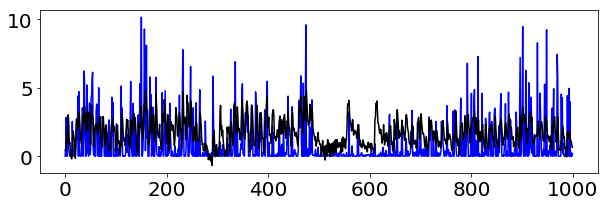

In [88]:
plt.figure(figsize=(10,3))
fly_num = 4
section = 1
start = fly_num*3384+1000*section
end = fly_num*3384+1000*section+1000
plt.plot(behavior_super['Y_pos_units'][start:end],color=(0,0,1))
plt.plot((temporal_super[start:end,0]*-0.2)+1.7,color='k')

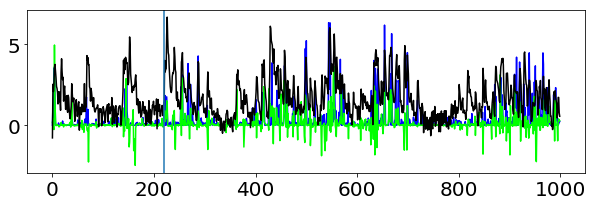

In [118]:
plt.figure(figsize=(10,3))
fly_num = 4
section = 0
start = fly_num*3384+1000*section
end = fly_num*3384+1000*section+1000
plt.plot(behavior_super['Y_pos_units'][start:end],color=(0,0,1))
plt.plot(behavior_super['Z_units'][start:end]/100,color=(0,1,0))

plt.plot((temporal_super[start:end,0]*-0.2)+1.7,color='k')

plt.axvline(220)

(600, 1000)

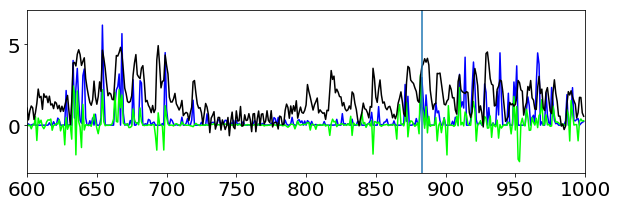

In [159]:
plt.figure(figsize=(10,3))
fly_num = 4
section = 0
start = fly_num*3384+1000*section
end = fly_num*3384+1000*section+1000
plt.plot(behavior_super['Y_pos_units'][start:end],color=(0,0,1))
plt.plot(behavior_super['Z_units'][start:end]/100,color=(0,1,0))

plt.plot((temporal_super[start:end,0]*-0.2)+1.7,color='k')

plt.axvline(4)
plt.axvline(38)
plt.axvline(67)
plt.axvline(883)

plt.xlim(600,1000)

In [131]:
def frame_num_to_video_time(frame_num):
    frame_rate = 0.532
    print(frame_num*frame_rate)

In [150]:
def video_time_to_frame_num(m, s):
    secs = m*60 + s
    frame_rate = 0.532
    print(secs/frame_rate)

In [158]:
video_time_to_frame_num(7, 50)

883.4586466165413


In [135]:
frame_num_to_video_time(4)
frame_num_to_video_time(38)
frame_num_to_video_time(67)

2.128
20.216
35.644000000000005


In [130]:
# frame number to video time
frame_num = 4
frame_rate = 0.532
frame_num*fram_rate

2.128

In [117]:
1000/532

1.8796992481203008

In [123]:
#one minute of video is
60/.532

112.78195488721803

In [116]:
# each step is a frame of length 532ms
(220*0.532)/60

1.9506666666666668

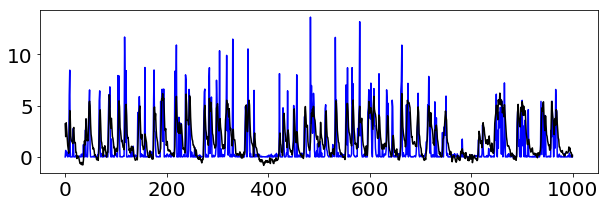

In [76]:
plt.figure(figsize=(10,3))
fly_num = 2
start = fly_num*3384+1000
end = fly_num*3384+2000
plt.plot(behavior_super['Y_pos_units'][start:end],color=(0,0,1))
plt.plot((temporal_super[start:end,0]*-0.2)+1.7,color='k')

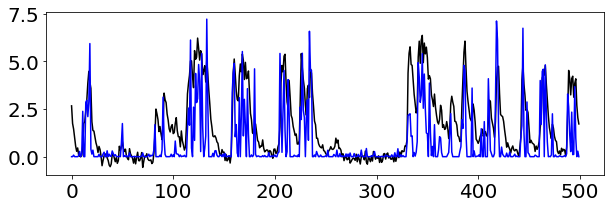

In [42]:
plt.figure(figsize=(10,3))
start = 8500
end = 9000
plt.plot((temporal_super[start:end,0]*-0.2)+1.7,color='k')
plt.plot(behavior_super['Y_pos_units'][start:end],color=(0,0,1))

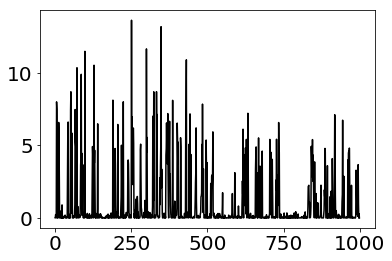

In [83]:
plt.plot(behavior_super['Y_pos_units'][start:end],color='k')